<a href="https://colab.research.google.com/github/Anvarka/RecSys/blob/master/RECSYS_HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://voudy-data.s3.eu-north-1.amazonaws.com/wsdm_data.tar.gz
!tar -xf /content/wsdm_data.tar.gz
!mkdir data
!mv -t data members.csv song_extra_info.csv songs.csv train.csv
!pip install catboost

--2021-12-14 22:56:02--  https://voudy-data.s3.eu-north-1.amazonaws.com/wsdm_data.tar.gz
Resolving proxy.odkl.ru (proxy.odkl.ru)... 10.107.16.6, 10.107.16.131, 10.107.16.67
Connecting to proxy.odkl.ru (proxy.odkl.ru)|10.107.16.6|:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 613394184 (585M) [application/x-gzip]
Saving to: ‘wsdm_data.tar.gz.1’

24% [========>                              ] 149,517,962 79.1MB/s             ^C
tar: /content/wsdm_data.tar.gz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now
mkdir: cannot create directory ‘data’: File exists
mv: cannot stat ‘members.csv’: No such file or directory
mv: cannot stat ‘song_extra_info.csv’: No such file or directory
mv: cannot stat ‘songs.csv’: No such file or directory
mv: cannot stat ‘train.csv’: No such file or directory
Looking in indexes: https://pypi.org/simple, https://nexus.odkl.ru/repository/pypi-dev-hosted/simple


In [ ]:
USER_ID = "msno"

# Первое задание
Собрать более-менее приличную рекомендательную систему с помощью GBDT. Использование трюков из лекции (и не из неё), тюнинг и разумных объемов фича инжиниринг прям нужен. 


Прочитаем данные:

In [ ]:
import pandas as pd
members_data = pd.read_csv("data/members.csv")
songs_info_data = pd.read_csv("data/song_extra_info.csv")
songs_data = pd.read_csv("data/songs.csv")
train_data = pd.read_csv("data/train.csv")

Объединим их вместе в одну большую таблицу:

In [ ]:
df = pd.merge(train_data, songs_data, on='song_id', how='left')
df = pd.merge(df, members_data, on='msno', how='left')
del members_data, songs_info_data, songs_data, train_data
df.head(2)

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,language,city,bd,gender,registered_via,registration_init_time,expiration_date
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,206471.0,359,Bastille,Dan Smith| Mark Crew,NaN,52.0,1,0,NaN,7,20120102,20171005
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,284584.0,1259,Various Artists,NaN,NaN,52.0,13,24,female,9,20110525,20170911


Тут даты записаны как-то слитно, давайте подправим их на нормальный формат: 

In [ ]:
df["registration_init_time"] = pd.to_datetime(df.registration_init_time, format='%Y%m%d', errors='ignore')
df["expiration_date"] = pd.to_datetime(df.expiration_date,  format='%Y%m%d', errors='ignore')
df.head(2)

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,language,city,bd,gender,registered_via,registration_init_time,expiration_date
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,206471.0,359,Bastille,Dan Smith| Mark Crew,NaN,52.0,1,0,NaN,7,2012-01-02,2017-10-05
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,284584.0,1259,Various Artists,NaN,NaN,52.0,13,24,female,9,2011-05-25,2017-09-11


Добавим еще пару фичей:

количество артистов:

In [ ]:
df["count_artist"] = df["artist_name"].astype(str).apply(lambda x: x.count("|") + x.count("and") + 1)

In [ ]:
df["count_composer"] = df["composer"].astype(str).apply(lambda x: x.count("|") + x.count("and") + 1)

In [ ]:
df["time_with_us"] = df["expiration_date"] - df["registration_init_time"]

In [ ]:
df.head(2)

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,...,language,city,bd,gender,registered_via,registration_init_time,expiration_date,count_artist,count_composer,time_with_us
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,206471.0,359,Bastille,Dan Smith| Mark Crew,...,52.0,1,0,NaN,7,2012-01-02,2017-10-05,1,2,2103 days
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,284584.0,1259,Various Artists,NaN,...,52.0,13,24,female,9,2011-05-25,2017-09-11,1,1,2301 days


Отлично, давайте определимся с категориальными фичами:


In [ ]:
features = ['msno', 'song_id', 'source_screen_name', 'source_type', 'target',
            'artist_name', 'composer', 'registration_init_time', 'genre_ids', 'count_artist',
            'count_composer', 'time_with_us']
# features = ['msno', 'song_id', 'target',
#             'artist_name', 'composer',  'genre_ids', 'count_artist',
#             'count_composer', 'time_with_us']

df = df[features]
df.head(2)

,msno,song_id,source_screen_name,source_type,target,artist_name,composer,registration_init_time,genre_ids,count_artist,count_composer,time_with_us
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,Explore,online-playlist,1,Bastille,Dan Smith| Mark Crew,2012-01-02,359,1,2,2103 days
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,Local playlist more,local-playlist,1,Various Artists,NaN,2011-05-25,1259,1,1,2301 days


Давайте превратим категориальные фичи в тип category, представим в виде вектора one_hot и запишем индексы:

In [ ]:
for col in features:
    df[col] = df[col].astype('category').cat.codes
    df[col].fillna("unknown")

df.head(2)

,msno,song_id,source_screen_name,source_type,target,artist_name,composer,registration_init_time,genre_ids,count_artist,count_composer,time_with_us
0,8158,74679,7,6,1,3277,14581,2131,285,0,1,2097
1,17259,223479,8,4,1,31960,-1,1909,90,0,0,2295


### Теперь обучим модель c помощью 5-fold и CatBoost. 

labels -- это target
data -- это все остальное, что мы оставили

In [ ]:
labels = df['target']
df.pop('target')

data = df

Обучаем:

In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import KFold
import numpy as np

pred_labels = np.zeros(len(labels))

for train_id, test_id in KFold(n_splits=5).split(data, labels):
    train_data = df.iloc[train_id]
    train_labels = labels.iloc[train_id]

    model = CatBoostClassifier(learning_rate=0.1, depth=10, iterations=300, task_type="GPU")
    model.fit(train_data, train_labels)

    pred_labels[test_id] = model.predict_proba(data.iloc[test_id])[:, 1]

0:	learn: 0.6864521	total: 34.6ms	remaining: 10.3s
1:	learn: 0.6810483	total: 66.9ms	remaining: 9.96s
2:	learn: 0.6767063	total: 98.4ms	remaining: 9.74s
3:	learn: 0.6732030	total: 129ms	remaining: 9.55s
4:	learn: 0.6703472	total: 159ms	remaining: 9.38s
5:	learn: 0.6680443	total: 190ms	remaining: 9.3s
6:	learn: 0.6661288	total: 220ms	remaining: 9.21s
7:	learn: 0.6645695	total: 250ms	remaining: 9.13s
8:	learn: 0.6633003	total: 280ms	remaining: 9.05s
9:	learn: 0.6622538	total: 311ms	remaining: 9.01s
10:	learn: 0.6613997	total: 339ms	remaining: 8.92s
11:	learn: 0.6605810	total: 369ms	remaining: 8.85s
12:	learn: 0.6599582	total: 397ms	remaining: 8.76s
13:	learn: 0.6593401	total: 425ms	remaining: 8.69s
14:	learn: 0.6589007	total: 455ms	remaining: 8.64s
15:	learn: 0.6584183	total: 483ms	remaining: 8.57s
16:	learn: 0.6580935	total: 509ms	remaining: 8.47s
17:	learn: 0.6577702	total: 536ms	remaining: 8.39s
18:	learn: 0.6574334	total: 563ms	remaining: 8.33s
19:	learn: 0.6571564	total: 591ms	remai

168:	learn: 0.6434913	total: 4.84s	remaining: 3.75s
169:	learn: 0.6434243	total: 4.87s	remaining: 3.72s
170:	learn: 0.6433696	total: 4.9s	remaining: 3.69s
171:	learn: 0.6433283	total: 4.92s	remaining: 3.66s
172:	learn: 0.6432834	total: 4.95s	remaining: 3.64s
173:	learn: 0.6432072	total: 4.98s	remaining: 3.61s
174:	learn: 0.6431657	total: 5.01s	remaining: 3.58s
175:	learn: 0.6431011	total: 5.04s	remaining: 3.55s
176:	learn: 0.6430537	total: 5.07s	remaining: 3.52s
177:	learn: 0.6430077	total: 5.1s	remaining: 3.49s
178:	learn: 0.6429334	total: 5.12s	remaining: 3.46s
179:	learn: 0.6428326	total: 5.15s	remaining: 3.43s
180:	learn: 0.6427685	total: 5.18s	remaining: 3.4s
181:	learn: 0.6427291	total: 5.21s	remaining: 3.38s
182:	learn: 0.6426791	total: 5.24s	remaining: 3.35s
183:	learn: 0.6426376	total: 5.26s	remaining: 3.32s
184:	learn: 0.6425547	total: 5.29s	remaining: 3.29s
185:	learn: 0.6424728	total: 5.32s	remaining: 3.26s
186:	learn: 0.6424276	total: 5.35s	remaining: 3.23s
187:	learn: 0.6

30:	learn: 0.6483619	total: 909ms	remaining: 7.89s
31:	learn: 0.6480873	total: 937ms	remaining: 7.85s
32:	learn: 0.6479277	total: 966ms	remaining: 7.82s
33:	learn: 0.6478000	total: 994ms	remaining: 7.78s
34:	learn: 0.6476644	total: 1.02s	remaining: 7.72s
35:	learn: 0.6475176	total: 1.05s	remaining: 7.7s
36:	learn: 0.6473316	total: 1.08s	remaining: 7.66s
37:	learn: 0.6471825	total: 1.11s	remaining: 7.63s
38:	learn: 0.6469701	total: 1.13s	remaining: 7.59s
39:	learn: 0.6468694	total: 1.16s	remaining: 7.56s
40:	learn: 0.6467704	total: 1.19s	remaining: 7.51s
41:	learn: 0.6465744	total: 1.22s	remaining: 7.48s
42:	learn: 0.6464772	total: 1.25s	remaining: 7.44s
43:	learn: 0.6462618	total: 1.27s	remaining: 7.41s
44:	learn: 0.6461806	total: 1.3s	remaining: 7.37s
45:	learn: 0.6460952	total: 1.33s	remaining: 7.34s
46:	learn: 0.6459649	total: 1.36s	remaining: 7.31s
47:	learn: 0.6458043	total: 1.39s	remaining: 7.27s
48:	learn: 0.6457238	total: 1.42s	remaining: 7.25s
49:	learn: 0.6456229	total: 1.44s

191:	learn: 0.6346998	total: 5.48s	remaining: 3.08s
192:	learn: 0.6346415	total: 5.51s	remaining: 3.06s
193:	learn: 0.6345818	total: 5.54s	remaining: 3.03s
194:	learn: 0.6345408	total: 5.57s	remaining: 3s
195:	learn: 0.6344820	total: 5.61s	remaining: 2.98s
196:	learn: 0.6344306	total: 5.64s	remaining: 2.95s
197:	learn: 0.6343938	total: 5.66s	remaining: 2.92s
198:	learn: 0.6343427	total: 5.69s	remaining: 2.89s
199:	learn: 0.6342740	total: 5.72s	remaining: 2.86s
200:	learn: 0.6342158	total: 5.75s	remaining: 2.83s
201:	learn: 0.6341293	total: 5.78s	remaining: 2.8s
202:	learn: 0.6340654	total: 5.8s	remaining: 2.77s
203:	learn: 0.6340319	total: 5.84s	remaining: 2.75s
204:	learn: 0.6339420	total: 5.86s	remaining: 2.72s
205:	learn: 0.6338642	total: 5.89s	remaining: 2.69s
206:	learn: 0.6338161	total: 5.92s	remaining: 2.66s
207:	learn: 0.6337319	total: 5.95s	remaining: 2.63s
208:	learn: 0.6336499	total: 5.98s	remaining: 2.6s
209:	learn: 0.6335889	total: 6.01s	remaining: 2.57s
210:	learn: 0.6335

54:	learn: 0.6412079	total: 1.55s	remaining: 6.92s
55:	learn: 0.6411036	total: 1.58s	remaining: 6.9s
56:	learn: 0.6410040	total: 1.61s	remaining: 6.88s
57:	learn: 0.6408950	total: 1.64s	remaining: 6.86s
58:	learn: 0.6406725	total: 1.67s	remaining: 6.83s
59:	learn: 0.6405690	total: 1.7s	remaining: 6.82s
60:	learn: 0.6405029	total: 1.73s	remaining: 6.79s
61:	learn: 0.6403764	total: 1.76s	remaining: 6.76s
62:	learn: 0.6402090	total: 1.79s	remaining: 6.73s
63:	learn: 0.6400728	total: 1.82s	remaining: 6.7s
64:	learn: 0.6399664	total: 1.84s	remaining: 6.67s
65:	learn: 0.6398758	total: 1.87s	remaining: 6.64s
66:	learn: 0.6397715	total: 1.9s	remaining: 6.62s
67:	learn: 0.6396449	total: 1.93s	remaining: 6.59s
68:	learn: 0.6395147	total: 1.96s	remaining: 6.57s
69:	learn: 0.6394373	total: 1.99s	remaining: 6.55s
70:	learn: 0.6393087	total: 2.02s	remaining: 6.52s
71:	learn: 0.6391976	total: 2.05s	remaining: 6.49s
72:	learn: 0.6391157	total: 2.08s	remaining: 6.47s
73:	learn: 0.6390281	total: 2.11s	r

219:	learn: 0.6287706	total: 6.29s	remaining: 2.29s
220:	learn: 0.6287398	total: 6.32s	remaining: 2.26s
221:	learn: 0.6286924	total: 6.35s	remaining: 2.23s
222:	learn: 0.6286385	total: 6.38s	remaining: 2.2s
223:	learn: 0.6286132	total: 6.41s	remaining: 2.17s
224:	learn: 0.6285507	total: 6.44s	remaining: 2.15s
225:	learn: 0.6284715	total: 6.47s	remaining: 2.12s
226:	learn: 0.6284078	total: 6.49s	remaining: 2.09s
227:	learn: 0.6283440	total: 6.52s	remaining: 2.06s
228:	learn: 0.6282741	total: 6.55s	remaining: 2.03s
229:	learn: 0.6282260	total: 6.58s	remaining: 2s
230:	learn: 0.6281618	total: 6.61s	remaining: 1.97s
231:	learn: 0.6281141	total: 6.64s	remaining: 1.95s
232:	learn: 0.6280430	total: 6.68s	remaining: 1.92s
233:	learn: 0.6280170	total: 6.71s	remaining: 1.89s
234:	learn: 0.6279820	total: 6.74s	remaining: 1.86s
235:	learn: 0.6279344	total: 6.77s	remaining: 1.83s
236:	learn: 0.6278481	total: 6.8s	remaining: 1.81s
237:	learn: 0.6278103	total: 6.83s	remaining: 1.78s
238:	learn: 0.627

86:	learn: 0.6353126	total: 2.41s	remaining: 5.9s
87:	learn: 0.6352040	total: 2.44s	remaining: 5.87s
88:	learn: 0.6351383	total: 2.46s	remaining: 5.84s
89:	learn: 0.6350738	total: 2.49s	remaining: 5.82s
90:	learn: 0.6349885	total: 2.52s	remaining: 5.79s
91:	learn: 0.6349357	total: 2.55s	remaining: 5.76s
92:	learn: 0.6348327	total: 2.57s	remaining: 5.73s
93:	learn: 0.6347364	total: 2.6s	remaining: 5.7s
94:	learn: 0.6346611	total: 2.63s	remaining: 5.67s
95:	learn: 0.6346030	total: 2.66s	remaining: 5.65s
96:	learn: 0.6344723	total: 2.68s	remaining: 5.62s
97:	learn: 0.6343621	total: 2.71s	remaining: 5.59s
98:	learn: 0.6342397	total: 2.74s	remaining: 5.57s
99:	learn: 0.6341435	total: 2.77s	remaining: 5.54s
100:	learn: 0.6340567	total: 2.8s	remaining: 5.51s
101:	learn: 0.6339401	total: 2.82s	remaining: 5.48s
102:	learn: 0.6338323	total: 2.85s	remaining: 5.45s
103:	learn: 0.6337293	total: 2.88s	remaining: 5.42s
104:	learn: 0.6336381	total: 2.91s	remaining: 5.4s
105:	learn: 0.6335628	total: 2.

248:	learn: 0.6245581	total: 7s	remaining: 1.43s
249:	learn: 0.6244874	total: 7.03s	remaining: 1.41s
250:	learn: 0.6244205	total: 7.05s	remaining: 1.38s
251:	learn: 0.6243633	total: 7.08s	remaining: 1.35s
252:	learn: 0.6242851	total: 7.11s	remaining: 1.32s
253:	learn: 0.6242371	total: 7.14s	remaining: 1.29s
254:	learn: 0.6242121	total: 7.16s	remaining: 1.26s
255:	learn: 0.6241522	total: 7.19s	remaining: 1.24s
256:	learn: 0.6241273	total: 7.22s	remaining: 1.21s
257:	learn: 0.6240888	total: 7.25s	remaining: 1.18s
258:	learn: 0.6240487	total: 7.28s	remaining: 1.15s
259:	learn: 0.6240099	total: 7.31s	remaining: 1.12s
260:	learn: 0.6239839	total: 7.34s	remaining: 1.1s
261:	learn: 0.6239482	total: 7.36s	remaining: 1.07s
262:	learn: 0.6238734	total: 7.39s	remaining: 1.04s
263:	learn: 0.6238196	total: 7.42s	remaining: 1.01s
264:	learn: 0.6237591	total: 7.44s	remaining: 983ms
265:	learn: 0.6236987	total: 7.47s	remaining: 955ms
266:	learn: 0.6236640	total: 7.5s	remaining: 927ms
267:	learn: 0.623

112:	learn: 0.6314257	total: 3.26s	remaining: 5.39s
113:	learn: 0.6313626	total: 3.29s	remaining: 5.37s
114:	learn: 0.6312932	total: 3.32s	remaining: 5.34s
115:	learn: 0.6312133	total: 3.35s	remaining: 5.31s
116:	learn: 0.6311440	total: 3.37s	remaining: 5.28s
117:	learn: 0.6310697	total: 3.4s	remaining: 5.25s
118:	learn: 0.6309591	total: 3.43s	remaining: 5.22s
119:	learn: 0.6308868	total: 3.46s	remaining: 5.19s
120:	learn: 0.6308174	total: 3.49s	remaining: 5.16s
121:	learn: 0.6307328	total: 3.52s	remaining: 5.13s
122:	learn: 0.6306684	total: 3.54s	remaining: 5.1s
123:	learn: 0.6306069	total: 3.57s	remaining: 5.07s
124:	learn: 0.6305456	total: 3.6s	remaining: 5.04s
125:	learn: 0.6304825	total: 3.63s	remaining: 5.01s
126:	learn: 0.6304254	total: 3.66s	remaining: 4.99s
127:	learn: 0.6303556	total: 3.69s	remaining: 4.96s
128:	learn: 0.6302503	total: 3.72s	remaining: 4.93s
129:	learn: 0.6302024	total: 3.75s	remaining: 4.9s
130:	learn: 0.6301483	total: 3.77s	remaining: 4.87s
131:	learn: 0.63

277:	learn: 0.6217143	total: 7.98s	remaining: 631ms
278:	learn: 0.6216749	total: 8.01s	remaining: 603ms
279:	learn: 0.6216432	total: 8.03s	remaining: 574ms
280:	learn: 0.6216120	total: 8.06s	remaining: 545ms
281:	learn: 0.6215471	total: 8.09s	remaining: 516ms
282:	learn: 0.6214833	total: 8.12s	remaining: 488ms
283:	learn: 0.6214125	total: 8.15s	remaining: 459ms
284:	learn: 0.6213540	total: 8.18s	remaining: 430ms
285:	learn: 0.6213193	total: 8.21s	remaining: 402ms
286:	learn: 0.6212857	total: 8.23s	remaining: 373ms
287:	learn: 0.6212534	total: 8.26s	remaining: 344ms
288:	learn: 0.6212257	total: 8.29s	remaining: 316ms
289:	learn: 0.6211718	total: 8.32s	remaining: 287ms
290:	learn: 0.6211247	total: 8.35s	remaining: 258ms
291:	learn: 0.6210911	total: 8.37s	remaining: 229ms
292:	learn: 0.6210523	total: 8.4s	remaining: 201ms
293:	learn: 0.6209831	total: 8.43s	remaining: 172ms
294:	learn: 0.6209393	total: 8.46s	remaining: 143ms
295:	learn: 0.6209081	total: 8.48s	remaining: 115ms
296:	learn: 0

In [ ]:
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

user_ids = np.unique(data["msno"])
aucs = []

for user_id in tqdm(user_ids):
    true_labels_of_cur_user = labels[user_id == data["msno"]]
    pred_labels_of_cur_user = pred_labels[user_id == data["msno"]]
    try:
        auc = roc_auc_score(true_labels_of_cur_user, pred_labels_of_cur_user )
    except ValueError:
        pass
    aucs.append(auc)

100%|██████████| 30755/30755 [05:01<00:00, 101.93it/s]


In [ ]:
print("AUC: ", np.array(aucs).mean())

AUC:  0.6125174005215328


In [ ]:
for name, importance in zip(df, model.get_feature_importance()):
    print(f"{name}: {importance}")

msno: 8.414014581034117
song_id: 4.676681472156767
source_screen_name: 12.400307974631325
source_type: 30.663750992673716
artist_name: 7.834258106000617
composer: 7.563387846856306
registration_init_time: 8.52530676752588
genre_ids: 7.510788506548439
count_artist: 0.18276115462588208
count_composer: 1.946487945353052
time_with_us: 10.282254652593913


### Второе задание

Пользуясь информацией о треках построить неклассические эмбеддинги и попробовать использовать их:

а) показать симилары глазами
б) в качестве рекоммендера вместо GBDT (разницу в метриках) 
в) стек с GBDT (прирост / отсутствие / почему /, SHAP values)


#### подготовка данных для подсчета эмбеддингов

теперь данное 

In [ ]:
from gensim.models import Word2Vec
USER_ID = "msno"
df["song_id"] = df["song_id"].astype(str)
user_and_his_songs = dict(df.groupby(USER_ID)["song_id"].agg(lambda x: x.tolist()))
songs = [list_of_songs for list_of_songs in user_and_his_songs.values() if len(list_of_songs) > 0]

/home/a.tliamov/anaconda3/envs/py36/lib/python3.6/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


обучение word2vec по песням:

In [ ]:
word2vec = Word2Vec(vector_size=128, window=5, min_count=5, workers=15)
word2vec.build_vocab(songs)
word2vec.train(songs, total_examples=word2vec.corpus_count, epochs=10)
all_song_embeddings = word2vec.wv

#### Получим эмбеддинги песен и пользователей:

В качестве эмбеддинга пользователя возьмем среднее по его прослушанным песням

In [ ]:
users_songs = dict(df[labels == 1].groupby(USER_ID).song_id.apply(list))
import numpy as np
user_embs_dict = {}
for user_id, song_ids in users_songs.items():
    user_emb = np.mean([all_song_embeddings[song_id] for song_id in song_ids if song_id in all_song_embeddings], axis=0)
    user_embs_dict[user_id] = user_emb


/home/a.tliamov/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/a.tliamov/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


теперь попробуем вытащить симилары:

надо вытащить самые популярные категории и 

In [ ]:
sort_categories_of_song = df.groupby("genre_ids").count().sort_values("song_id", ascending=False).index.to_list()
most_popular_categories = sort_categories_of_song[1:5]
genress = df[df["genre_ids"].isin(most_popular_categories)][:1000]

In [ ]:
df.groupby("genre_ids").count().sort_values("song_id", ascending=False)

,msno,song_id,source_screen_name,source_type,artist_name,composer,registration_init_time,count_artist,count_composer,time_with_us
genre_ids,,,,,,,,,,
344,3717690,3717690,3717690,3717690,3717690,3717690,3717690,3717690,3717690,3717690
337,1261208,1261208,1261208,1261208,1261208,1261208,1261208,1261208,1261208,1261208
515,350311,350311,350311,350311,350311,350311,350311,350311,350311,350311
120,315089,315089,315089,315089,315089,315089,315089,315089,315089,315089
323,243600,243600,243600,243600,243600,243600,243600,243600,243600,243600
...,...,...,...,...,...,...,...,...,...,...
370,1,1,1,1,1,1,1,1,1,1
372,1,1,1,1,1,1,1,1,1,1
374,1,1,1,1,1,1,1,1,1,1


In [ ]:
songs_x = list(x for x in set(genress['song_id'].unique()) if x in all_song_embeddings)

genress = genress[genress['song_id'].isin(songs_x)]
songs = genress['song_id']
genres = genress['genre_ids']

a) Покажем симилары глазами

In [ ]:
# !pip uninstall umap
# !pip install umap-learn
import seaborn as sns
import umap.umap_ as umap

fit = umap.UMAP(n_neighbors=20, n_components=2,
    random_state=42, min_dist = 0.00, )
%time u = fit.fit_transform(all_song_embeddings[songs])
u

/home/a.tliamov/anaconda3/envs/py36/lib/python3.6/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 6103. The TBB threading layer is disabled.
  warnings.warn(problem)


CPU times: user 12.9 s, sys: 3.35 s, total: 16.2 s
Wall time: 11.7 s


array([[ 0.03025674,  9.744772  ],
       [ 1.9851182 ,  8.4541235 ],
       [ 6.1609974 ,  9.722905  ],
       ...,
       [ 5.58442   , 12.337702  ],
       [ 4.5793843 , 11.314801  ],
       [ 7.6315303 , 11.8727665 ]], dtype=float32)

In [ ]:
uniq = set(genres.to_list())
dict_obj = {}
for i, label in enumerate(uniq):
    dict_obj[label] = i

filter_labels = []
for label in genres.to_list():
    filter_labels.append(dict_obj[label])

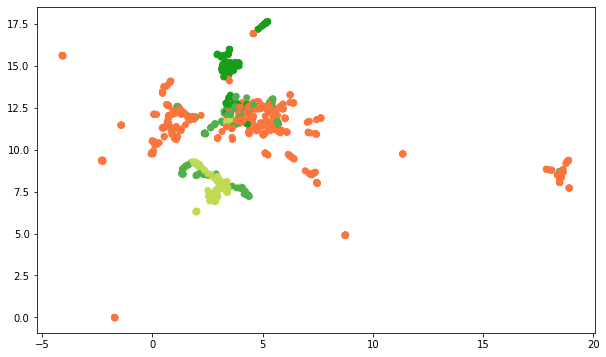

In [ ]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.cm as cm
import numpy as np
import matplotlib.pyplot as plt

def visualize_clasters(X, labels):
    unique_labels = np.unique(labels)
    unique_colors = np.random.random((len(unique_labels), 3))
    colors = [unique_colors[l] for l in labels]
    plt.figure(figsize=(10, 6))
    plt.scatter(X[:, 0], X[:, 1], c=colors)
    plt.show()

visualize_clasters(u, filter_labels)

б) Используем в качестве рекоммендера

In [ ]:
from tqdm import tqdm

preds = []
user_and_song = df[[USER_ID, 'song_id']]

for msno, song in tqdm(user_and_song.values):
    if not song in all_song_embeddings:
        preds.append(False)
        continue
    song_emb = all_song_embeddings[song]
    user_emb = user_embs_dict[user_and_song["msno"][0]]
    preds.append(np.dot(user_emb, song_emb) / (np.norm(user_emb) * np.norm(song_emb)))

100%|██████████| 7377418/7377418 [44:25<00:00, 2767.97it/s]


In [ ]:
df["pred"] = preds
#df = df[df["pred"] != False]

In [ ]:
err = pd.DataFrame()
err["preds"] = preds 
labels = labels[err["preds"] != False]
# del err

In [ ]:
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

user_ids = np.unique(df[USER_ID])
aucs = []

for user_id in tqdm(user_ids):
    true_labels_of_cur_user = labels[user_id == df[USER_ID]]
    pred_labels_of_cur_user = df[user_id == df[USER_ID]]["pred"]
    try:
        auc = roc_auc_score(true_labels_of_cur_user, pred_labels_of_cur_user )
    except ValueError:
        pass
    aucs.append(auc)

100%|██████████| 30671/30671 [10:19<00:00, 49.48it/s]


In [ ]:
print("AUC: ", np.array(aucs).mean())

AUC:  0.48967736642031


Закешируем:

In [ ]:
df_cache = df
df_cache['target'] = labels
df_cache.to_csv("df_cache.txt", sep="\t", index=None)

/home/a.tliamov/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
import pandas as pd
df = pd.read_csv("df_cache.txt", sep="\t")

в) стек с GBDT

Наш df теперь имеет дополнительное поле с предсказаниями. Посмотрим как теперь обучится CatBoost:

In [ ]:
pred_labels = np.zeros(len(labels))

for train_id, test_id in KFold(n_splits=5).split(df, labels):
    train_data = df.iloc[train_id]
    train_labels = labels.iloc[train_id]

    model2 = CatBoostClassifier(learning_rate=0.1, depth=10, iterations=300, task_type="GPU")
    model2.fit(train_data, train_labels)

    pred_labels[test_id] = model2.predict_proba(df.iloc[test_id])[:, 1]

0:	learn: 0.6864847	total: 31.7ms	remaining: 9.47s
1:	learn: 0.6811324	total: 62.1ms	remaining: 9.26s
2:	learn: 0.6768049	total: 92ms	remaining: 9.11s
3:	learn: 0.6732452	total: 123ms	remaining: 9.08s
4:	learn: 0.6704119	total: 154ms	remaining: 9.07s
5:	learn: 0.6681325	total: 182ms	remaining: 8.9s
6:	learn: 0.6662468	total: 209ms	remaining: 8.75s
7:	learn: 0.6646600	total: 237ms	remaining: 8.66s
8:	learn: 0.6632974	total: 266ms	remaining: 8.62s
9:	learn: 0.6622625	total: 294ms	remaining: 8.53s
10:	learn: 0.6613375	total: 324ms	remaining: 8.52s
11:	learn: 0.6605438	total: 351ms	remaining: 8.44s
12:	learn: 0.6598558	total: 378ms	remaining: 8.34s
13:	learn: 0.6592745	total: 404ms	remaining: 8.26s
14:	learn: 0.6587011	total: 431ms	remaining: 8.2s
15:	learn: 0.6582055	total: 458ms	remaining: 8.13s
16:	learn: 0.6577962	total: 484ms	remaining: 8.05s
17:	learn: 0.6574501	total: 510ms	remaining: 7.99s
18:	learn: 0.6571277	total: 536ms	remaining: 7.93s
19:	learn: 0.6567978	total: 564ms	remainin

163:	learn: 0.6427985	total: 4.63s	remaining: 3.84s
164:	learn: 0.6427361	total: 4.65s	remaining: 3.81s
165:	learn: 0.6426908	total: 4.68s	remaining: 3.78s
166:	learn: 0.6426396	total: 4.71s	remaining: 3.75s
167:	learn: 0.6426036	total: 4.74s	remaining: 3.72s
168:	learn: 0.6425005	total: 4.77s	remaining: 3.69s
169:	learn: 0.6424622	total: 4.79s	remaining: 3.67s
170:	learn: 0.6424092	total: 4.82s	remaining: 3.64s
171:	learn: 0.6423471	total: 4.85s	remaining: 3.61s
172:	learn: 0.6422850	total: 4.88s	remaining: 3.58s
173:	learn: 0.6422596	total: 4.91s	remaining: 3.55s
174:	learn: 0.6422081	total: 4.94s	remaining: 3.52s
175:	learn: 0.6421327	total: 4.96s	remaining: 3.5s
176:	learn: 0.6420555	total: 4.99s	remaining: 3.47s
177:	learn: 0.6420219	total: 5.02s	remaining: 3.44s
178:	learn: 0.6419904	total: 5.05s	remaining: 3.41s
179:	learn: 0.6419484	total: 5.08s	remaining: 3.38s
180:	learn: 0.6418858	total: 5.11s	remaining: 3.36s
181:	learn: 0.6418319	total: 5.13s	remaining: 3.33s
182:	learn: 0

23:	learn: 0.6480906	total: 686ms	remaining: 7.89s
24:	learn: 0.6478829	total: 712ms	remaining: 7.83s
25:	learn: 0.6477367	total: 738ms	remaining: 7.78s
26:	learn: 0.6475507	total: 765ms	remaining: 7.74s
27:	learn: 0.6472880	total: 792ms	remaining: 7.7s
28:	learn: 0.6471157	total: 820ms	remaining: 7.66s
29:	learn: 0.6468730	total: 847ms	remaining: 7.63s
30:	learn: 0.6467155	total: 877ms	remaining: 7.61s
31:	learn: 0.6465244	total: 904ms	remaining: 7.57s
32:	learn: 0.6463839	total: 932ms	remaining: 7.54s
33:	learn: 0.6462235	total: 958ms	remaining: 7.5s
34:	learn: 0.6461094	total: 985ms	remaining: 7.46s
35:	learn: 0.6458958	total: 1.01s	remaining: 7.42s
36:	learn: 0.6456570	total: 1.04s	remaining: 7.39s
37:	learn: 0.6455235	total: 1.07s	remaining: 7.35s
38:	learn: 0.6453487	total: 1.09s	remaining: 7.32s
39:	learn: 0.6452512	total: 1.12s	remaining: 7.3s
40:	learn: 0.6451317	total: 1.15s	remaining: 7.28s
41:	learn: 0.6450238	total: 1.18s	remaining: 7.25s
42:	learn: 0.6448292	total: 1.21s	

190:	learn: 0.6330669	total: 5.31s	remaining: 3.03s
191:	learn: 0.6330209	total: 5.34s	remaining: 3s
192:	learn: 0.6329502	total: 5.37s	remaining: 2.98s
193:	learn: 0.6328889	total: 5.39s	remaining: 2.95s
194:	learn: 0.6328422	total: 5.42s	remaining: 2.92s
195:	learn: 0.6327867	total: 5.45s	remaining: 2.89s
196:	learn: 0.6327241	total: 5.48s	remaining: 2.86s
197:	learn: 0.6326945	total: 5.51s	remaining: 2.84s
198:	learn: 0.6326554	total: 5.54s	remaining: 2.81s
199:	learn: 0.6325980	total: 5.56s	remaining: 2.78s
200:	learn: 0.6325201	total: 5.59s	remaining: 2.75s
201:	learn: 0.6324710	total: 5.62s	remaining: 2.73s
202:	learn: 0.6324055	total: 5.64s	remaining: 2.7s
203:	learn: 0.6323491	total: 5.67s	remaining: 2.67s
204:	learn: 0.6322586	total: 5.7s	remaining: 2.64s
205:	learn: 0.6321997	total: 5.73s	remaining: 2.61s
206:	learn: 0.6321540	total: 5.75s	remaining: 2.58s
207:	learn: 0.6321079	total: 5.78s	remaining: 2.56s
208:	learn: 0.6320494	total: 5.82s	remaining: 2.53s
209:	learn: 0.631

56:	learn: 0.6382849	total: 1.56s	remaining: 6.66s
57:	learn: 0.6382070	total: 1.59s	remaining: 6.64s
58:	learn: 0.6380677	total: 1.62s	remaining: 6.61s
59:	learn: 0.6379622	total: 1.65s	remaining: 6.58s
60:	learn: 0.6378728	total: 1.68s	remaining: 6.57s
61:	learn: 0.6377518	total: 1.7s	remaining: 6.54s
62:	learn: 0.6376625	total: 1.73s	remaining: 6.52s
63:	learn: 0.6375269	total: 1.76s	remaining: 6.5s
64:	learn: 0.6374337	total: 1.79s	remaining: 6.47s
65:	learn: 0.6373132	total: 1.82s	remaining: 6.46s
66:	learn: 0.6371562	total: 1.85s	remaining: 6.44s
67:	learn: 0.6370545	total: 1.88s	remaining: 6.42s
68:	learn: 0.6368935	total: 1.91s	remaining: 6.39s
69:	learn: 0.6368164	total: 1.94s	remaining: 6.37s
70:	learn: 0.6366535	total: 1.97s	remaining: 6.34s
71:	learn: 0.6365467	total: 1.99s	remaining: 6.31s
72:	learn: 0.6364384	total: 2.02s	remaining: 6.29s
73:	learn: 0.6363584	total: 2.05s	remaining: 6.26s
74:	learn: 0.6362682	total: 2.08s	remaining: 6.23s
75:	learn: 0.6361842	total: 2.1s	

220:	learn: 0.6262419	total: 6.16s	remaining: 2.2s
221:	learn: 0.6261821	total: 6.19s	remaining: 2.17s
222:	learn: 0.6261258	total: 6.21s	remaining: 2.15s
223:	learn: 0.6260950	total: 6.24s	remaining: 2.12s
224:	learn: 0.6260664	total: 6.27s	remaining: 2.09s
225:	learn: 0.6259785	total: 6.3s	remaining: 2.06s
226:	learn: 0.6259104	total: 6.33s	remaining: 2.04s
227:	learn: 0.6258731	total: 6.36s	remaining: 2.01s
228:	learn: 0.6257950	total: 6.38s	remaining: 1.98s
229:	learn: 0.6257564	total: 6.41s	remaining: 1.95s
230:	learn: 0.6256907	total: 6.44s	remaining: 1.92s
231:	learn: 0.6256558	total: 6.47s	remaining: 1.9s
232:	learn: 0.6256222	total: 6.49s	remaining: 1.87s
233:	learn: 0.6255385	total: 6.52s	remaining: 1.84s
234:	learn: 0.6254878	total: 6.55s	remaining: 1.81s
235:	learn: 0.6254070	total: 6.58s	remaining: 1.78s
236:	learn: 0.6253447	total: 6.6s	remaining: 1.75s
237:	learn: 0.6252941	total: 6.63s	remaining: 1.73s
238:	learn: 0.6252422	total: 6.66s	remaining: 1.7s
239:	learn: 0.625

80:	learn: 0.6327163	total: 2.22s	remaining: 6.01s
81:	learn: 0.6326153	total: 2.25s	remaining: 5.98s
82:	learn: 0.6325552	total: 2.28s	remaining: 5.95s
83:	learn: 0.6324717	total: 2.3s	remaining: 5.93s
84:	learn: 0.6323225	total: 2.33s	remaining: 5.89s
85:	learn: 0.6322159	total: 2.36s	remaining: 5.87s
86:	learn: 0.6321454	total: 2.39s	remaining: 5.84s
87:	learn: 0.6320368	total: 2.41s	remaining: 5.82s
88:	learn: 0.6319362	total: 2.44s	remaining: 5.79s
89:	learn: 0.6318732	total: 2.47s	remaining: 5.77s
90:	learn: 0.6317984	total: 2.5s	remaining: 5.75s
91:	learn: 0.6317100	total: 2.54s	remaining: 5.75s
92:	learn: 0.6315877	total: 2.57s	remaining: 5.72s
93:	learn: 0.6314791	total: 2.6s	remaining: 5.69s
94:	learn: 0.6314009	total: 2.62s	remaining: 5.66s
95:	learn: 0.6313200	total: 2.65s	remaining: 5.63s
96:	learn: 0.6312343	total: 2.68s	remaining: 5.61s
97:	learn: 0.6311815	total: 2.71s	remaining: 5.59s
98:	learn: 0.6310688	total: 2.74s	remaining: 5.56s
99:	learn: 0.6309875	total: 2.77s	

246:	learn: 0.6219564	total: 6.84s	remaining: 1.47s
247:	learn: 0.6218979	total: 6.86s	remaining: 1.44s
248:	learn: 0.6218279	total: 6.89s	remaining: 1.41s
249:	learn: 0.6217595	total: 6.92s	remaining: 1.38s
250:	learn: 0.6216909	total: 6.95s	remaining: 1.36s
251:	learn: 0.6216306	total: 6.98s	remaining: 1.33s
252:	learn: 0.6215838	total: 7.01s	remaining: 1.3s
253:	learn: 0.6215198	total: 7.04s	remaining: 1.27s
254:	learn: 0.6213931	total: 7.06s	remaining: 1.25s
255:	learn: 0.6213422	total: 7.09s	remaining: 1.22s
256:	learn: 0.6212877	total: 7.12s	remaining: 1.19s
257:	learn: 0.6212457	total: 7.15s	remaining: 1.16s
258:	learn: 0.6211876	total: 7.18s	remaining: 1.14s
259:	learn: 0.6211229	total: 7.21s	remaining: 1.11s
260:	learn: 0.6210935	total: 7.24s	remaining: 1.08s
261:	learn: 0.6210580	total: 7.27s	remaining: 1.05s
262:	learn: 0.6210136	total: 7.3s	remaining: 1.03s
263:	learn: 0.6209848	total: 7.33s	remaining: 999ms
264:	learn: 0.6209590	total: 7.35s	remaining: 971ms
265:	learn: 0.

111:	learn: 0.6286079	total: 3.07s	remaining: 5.15s
112:	learn: 0.6285252	total: 3.09s	remaining: 5.12s
113:	learn: 0.6284551	total: 3.12s	remaining: 5.09s
114:	learn: 0.6283741	total: 3.15s	remaining: 5.06s
115:	learn: 0.6283150	total: 3.17s	remaining: 5.04s
116:	learn: 0.6282220	total: 3.2s	remaining: 5.01s
117:	learn: 0.6281725	total: 3.23s	remaining: 4.99s
118:	learn: 0.6281153	total: 3.26s	remaining: 4.96s
119:	learn: 0.6280428	total: 3.29s	remaining: 4.93s
120:	learn: 0.6279389	total: 3.31s	remaining: 4.9s
121:	learn: 0.6278305	total: 3.34s	remaining: 4.87s
122:	learn: 0.6277588	total: 3.36s	remaining: 4.84s
123:	learn: 0.6276797	total: 3.39s	remaining: 4.82s
124:	learn: 0.6276268	total: 3.42s	remaining: 4.79s
125:	learn: 0.6275848	total: 3.45s	remaining: 4.76s
126:	learn: 0.6275065	total: 3.48s	remaining: 4.74s
127:	learn: 0.6274159	total: 3.5s	remaining: 4.71s
128:	learn: 0.6273473	total: 3.53s	remaining: 4.68s
129:	learn: 0.6272832	total: 3.56s	remaining: 4.65s
130:	learn: 0.6

270:	learn: 0.6189115	total: 7.45s	remaining: 797ms
271:	learn: 0.6188112	total: 7.47s	remaining: 769ms
272:	learn: 0.6187857	total: 7.5s	remaining: 742ms
273:	learn: 0.6187396	total: 7.53s	remaining: 715ms
274:	learn: 0.6186545	total: 7.56s	remaining: 687ms
275:	learn: 0.6185855	total: 7.58s	remaining: 659ms
276:	learn: 0.6185555	total: 7.61s	remaining: 632ms
277:	learn: 0.6184920	total: 7.64s	remaining: 604ms
278:	learn: 0.6184437	total: 7.67s	remaining: 577ms
279:	learn: 0.6184135	total: 7.7s	remaining: 550ms
280:	learn: 0.6183478	total: 7.73s	remaining: 522ms
281:	learn: 0.6183058	total: 7.75s	remaining: 495ms
282:	learn: 0.6182654	total: 7.78s	remaining: 468ms
283:	learn: 0.6181745	total: 7.81s	remaining: 440ms
284:	learn: 0.6181361	total: 7.84s	remaining: 412ms
285:	learn: 0.6181038	total: 7.86s	remaining: 385ms
286:	learn: 0.6180781	total: 7.89s	remaining: 357ms
287:	learn: 0.6180219	total: 7.92s	remaining: 330ms
288:	learn: 0.6179632	total: 7.95s	remaining: 303ms
289:	learn: 0.

In [ ]:
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

user_ids = np.unique(df["msno"])
aucs = []

for user_id in tqdm(user_ids):
    true_labels_of_cur_user = labels[user_id == df["msno"]]
    pred_labels_of_cur_user = pred_labels[user_id == df["msno"]]
    try:
        auc = roc_auc_score(true_labels_of_cur_user, pred_labels_of_cur_user)
        aucs.append(auc)
    except ValueError:
        pass

100%|██████████| 30671/30671 [10:06<00:00, 50.59it/s]


In [ ]:
print("AUC: ", np.array(aucs).mean())

AUC:  0.6179997810783421


In [ ]:
model2.get_feature_importance()

array([ 8.23321677,  3.05073001, 10.8235254 , 31.64086225,  5.62726811,
        5.13652187,  8.32059076,  5.67626483,  0.11281428,  1.53235957,
       10.1511845 ,  9.69466165])

In [ ]:
for name, importance in zip(df, model2.get_feature_importance()):
    print(f"{name}: {importance}")

msno: 8.233216770826703
song_id: 3.0507300077044865
source_screen_name: 10.823525396272133
source_type: 31.640862249046798
artist_name: 5.6272681119737475
composer: 5.136521867443378
registration_init_time: 8.320590764127347
genre_ids: 5.676264826662236
count_artist: 0.11281427974815193
count_composer: 1.5323595739540614
time_with_us: 10.151184497656779
pred: 9.694661654584198


Метрика AUC выросла немного за счет pred.